# Hymba: A Hybrid-head Architecture for Small Language Models

## Paper Review & Implementation

---

이번에 톺아볼 논문은 바로 **'Hymba: A Hybrid-head Architecture for Small Language Models'**입니다. 

간단하게 말하자면 이전에 Diff Transformer를 구현하는 과정에서 만들었던 **Transformer(Llama)와 Mamba를 병렬로 연결한 모델**입니다. 이를 통해 Transformer와 Mamba의 장점을 섞으면서도 단점은 희석시키기 위해 고안된 모델이며, 추가적으로 **'KV-Cache Sharing'**, **'Sliding Window Attention'**, **'Meta Token'**이 적용된 모델입니다.

이번 포스팅에선 Hymba를 구성하는 고유 구성 요소들을 단계적으로 구현하고 (llama block과 mamba는 이전에 구현했던 내용을 그대로 사용합니다. llama block에 대한 내용은 Differential Transformer에 대한 포스팅을, mamba block에 대한 내용은 Mamba에 대한 포스팅을 각각 참조하세요), 이전에 했던 것과 동일하게 **작은 셰익스피어 희곡 데이터셋에 학습시켜 성능을 확인**해보겠습니다.

### Reference
- **Paper**: [Hymba: A Hybrid-head Architecture for Small Language Models (arXiv:2411.13676)](https://arxiv.org/abs/2411.13676)
- **Official Code**: [NVIDIA Hymba on HuggingFace](https://huggingface.co/nvidia/Hymba-1.5B-Base)

## INTRO

본 논문[1]은 마치 이전의 ConvNeXt 논문 때와 같이 **꽤나 친절하게 쓰여진 편**에 속하는 논문인데요, 특히 아래와 같이 Hymba 구조를 **step-by-step으로 구현하는 과정** 및 그 과정으로 인해 얻을 수 있는 **효과를 잘 정리**해두었습니다.

![Design Roadmap](https://i.imgur.com/placeholder.png)
*Design Roadmap of Hymba (from [1])*

위 표에서 확인할 수 있듯이:
- **A**: Attention heads (sequential) - Transformer 블록을 순차적으로 추가
- **B**: Multi-head mixture (parallel) - Attention과 Mamba를 병렬로 연결
- **C**: Local/global attention - Sliding Window Attention과 Global Attention 혼합
- **D**: KV cache sharing - 인접 레이어 간 KV 캐시 공유
- **E**: Meta tokens - 학습 가능한 메타 토큰 추가

각 단계마다 **Recall 성능 향상**, **Throughput 증가**, **Cache Size 감소** 등의 효과를 정량적으로 제시하고 있습니다.

뿐만 아니라 본 모델을 학습 시킬 때 적용한 **Training Process**도 아래와 같이 공개되어 있습니다. (일반적으로 사용되는 방법론 - **대규모 비지도 학습 > 지도 학습 > 정제 지도 학습 > 강화 학습** - 이지만, 그 데이터의 규모나 특징이 잘 정리돼 있어 유용합니다)

![Training Process](https://i.imgur.com/placeholder2.png)
*Training Process (from [1])*

- **General pretraining**: 3.8T tokens, Cosmopedia+StarCoder 등 대규모 데이터셋
- **LR annealing**: 200B tokens, 고품질 데이터셋으로 추가 학습
- **SFT-1**: Code, Math, MKLU 등 함수 호출 및 전문 영역 데이터
- **SFT-2**: 950K samples의 고품질 instruction 데이터
- **DPO**: 200K samples로 preference optimization

본 리뷰에서는 위와 같은 수준의 학습 단계를 직접 실행해보긴 현실적으로 어려우므로, **모델 구조를 온전히 구현**하고, **각 구성 요소별로 어떤 효과를 얻을 수 있는지 확인**하는 정도로 마치도록 하겠습니다.

## Environment Setup

먼저 필요한 라이브러리들을 import하고 환경을 설정합니다.

In [1]:
import sys
import os
import warnings
sys.path.append('./backbone')

# Warning 제거
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from dataclasses import dataclass
from typing import Optional, List, Tuple
from enum import Enum

# 모듈 리로드
import importlib
if 'hymba' in sys.modules:
    importlib.reload(sys.modules['hymba'])

from hymba import (
    Hymba, HymbaConfig, ArchType, AttentionType
)

# 시각화 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# 디바이스
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"BF16 Support: {torch.cuda.is_bf16_supported()}")

Device: cuda
GPU: NVIDIA A100 80GB PCIe
BF16 Support: True


## Hymba Structure

우선 전체적인 구조를 살펴보고 가는 것이 좋습니다.

![Hymba Structure](https://i.imgur.com/placeholder3.png)
*Hymba Structure (from [1])*

가장 핵심은 당연히 위 그림에서도 볼 수 있듯 **SSM과 Attention을 병렬로 연결해 Hybrid Head를 구성**한다는 것입니다. 

이를 통해:
- **Mamba**의 전체 시퀀스에 대한 **흐름과 방향성을 빠르게 파악하는 능력**
- **Transformer**의 느리지만 **특정 정보에 대한 정밀한 작업 능력**

을 합쳐 **성능은 향상시키면서도 실행 속도는 그 중간에 위치**하게끔 한다는 전략적 구조인 셈입니다.

그리고 추가적으로 Transformer의 고질적인 문제를 해결하기 위해 크게 세 가지 대안이 추가되기도 하는데요, 각각:
1. **Meta Token**
2. **Attention Combination (Global + Local/SWA)**  
3. **KV Cache Sharing**

입니다. 이를 단계적으로 설명한 후, 코드로 구현해 그 성능을 살펴보도록 하겠습니다.

### Hymba Block Architecture

전체 Hymba 블록의 구조를 수식으로 표현하면 다음과 같습니다:

$$
\begin{align}
\mathbf{h}_0 &= \text{Embed}(\mathbf{x}) + \text{PosEmbed}(\mathbf{x}) \\
\mathbf{h}'_i &= \text{LayerNorm}(\mathbf{h}_{i-1}) \\
\mathbf{h}^{\text{ssm}}_i &= \text{Mamba}(\text{Proj}^{\text{ssm}}(\mathbf{h}'_i)) \\
\mathbf{h}^{\text{attn}}_i &= \text{Attention}(\text{Proj}^{\text{attn}}(\mathbf{h}'_i)) \\
\mathbf{h}_i &= \mathbf{h}_{i-1} + \text{Mean}(\text{GateNorm}(\mathbf{h}^{\text{ssm}}_i), \text{GateNorm}(\mathbf{h}^{\text{attn}}_i))
\end{align}
$$

여기서:
- $\mathbf{h}_i$: $i$-번째 레이어의 hidden state
- $\text{Mamba}$: SSM (State Space Model) 연산
- $\text{Attention}$: Global 또는 Local (SWA) attention
- $\text{GateNorm}$: Gating mechanism + Layer Normalization
- $\text{Mean}$: SSM과 Attention 출력의 평균

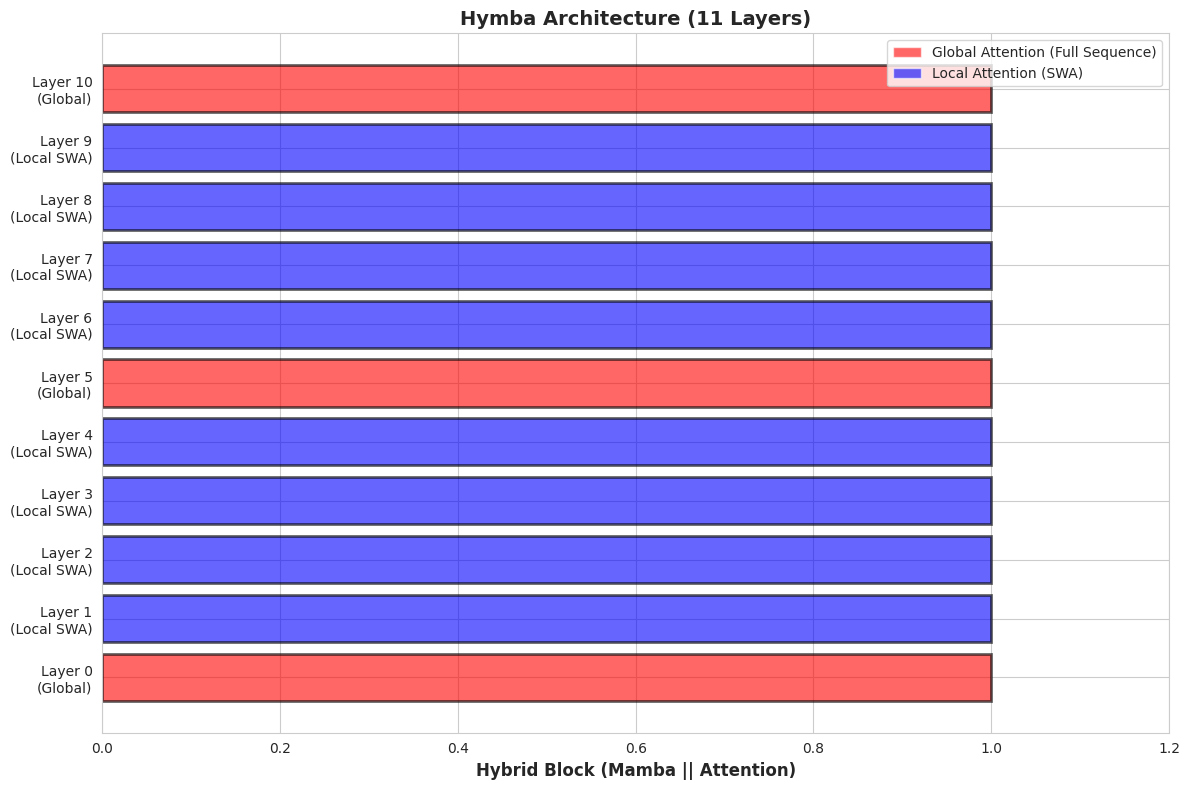


Architecture Statistics:
  Total Layers: 11
  Global Attention Layers: 3 (indices: [0, 5, 10])
  Local Attention Layers: 8
  Global/Local Ratio: 27.3% / 72.7%


In [2]:
# Hymba 아키텍처 시각화
def visualize_hymba_architecture(n_layers=11, global_indices=[0, 5, 10]):
    """
    Hymba 아키텍처를 시각화합니다.
    
    Args:
        n_layers: 전체 레이어 수
        global_indices: Global Attention이 적용되는 레이어 인덱스
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 레이어별로 색상 지정
    colors = []
    labels = []
    for i in range(n_layers):
        if i in global_indices:
            colors.append('red')
            labels.append(f'Layer {i}\n(Global)')
        else:
            colors.append('blue')
            labels.append(f'Layer {i}\n(Local SWA)')
    
    # 바 차트로 표시
    y_pos = np.arange(n_layers)
    ax.barh(y_pos, [1]*n_layers, color=colors, alpha=0.6, edgecolor='black', linewidth=2)
    
    # 레이블 추가
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Hybrid Block (Mamba || Attention)', fontsize=12, fontweight='bold')
    ax.set_title(f'Hymba Architecture ({n_layers} Layers)', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1.2)
    
    # 범례
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', alpha=0.6, label='Global Attention (Full Sequence)'),
        Patch(facecolor='blue', alpha=0.6, label='Local Attention (SWA)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('hymba_architecture.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 통계 출력
    print(f"\nArchitecture Statistics:")
    print(f"  Total Layers: {n_layers}")
    print(f"  Global Attention Layers: {len(global_indices)} (indices: {global_indices})")
    print(f"  Local Attention Layers: {n_layers - len(global_indices)}")
    print(f"  Global/Local Ratio: {len(global_indices)/n_layers:.1%} / {(n_layers-len(global_indices))/n_layers:.1%}")

# 시각화 실행
visualize_hymba_architecture(n_layers=11, global_indices=[0, 5, 10])

## #1 Meta Token

처음으로 살펴볼 것은 바로 **Meta Token**입니다. 

### 문제 상황: Attention Sink

최근의 여러 논문 및 연구들에서 **Transformer 기반 모델들이 필요 이상으로 제일 앞의 토큰에 큰 attention score를 분배하는 문제**를 확인했습니다. 어느 정도냐면, 일반적으로 문장의 앞에 추가되는 **BOS 토큰('Begin of Sentence')에 과반의 attention score가 집중**되는 문제가 있었습니다.

즉, **큰 의미가 없는 토큰에 attention score를 낭비하는 문제**가 발생하고 있고 이는 모델의 성능이 온전하게 발휘되지 못하는 문제를 야기하는데요, 아래 그림에서 확인할 수 있듯:
- 현대 Transformer 구조라 칭해지는 **Llama**: 56%
- 2024년 기준 가장 일반적으로 사용되는 Foundation Model 중 하나인 **Jamba** (attention과 mamba를 직렬로 연결한 hybrid 구조)의 attention: 무려 **62%**

의 attention score가 BOS 토큰에 할당된 것을 확인할 수 있습니다.

![Attention Distribution](https://i.imgur.com/placeholder4.png)
*Sum of attention score from different categories (from [1])*

- **BOS (붉은색)**: 첫 번째 토큰 (Begin of Sentence)
- **Cross (초록색)**: 다른 토큰들에 대한 attention
- **Self (주황색)**: 자기 자신에 대한 attention

### 해결 방안: Meta Token

이전에 리뷰했던 **Differential Transformer**에서는 이러한 문제 - 의미없는 토큰에 attention score를 할당하는 **Attention Noise 문제** - 를 해결하기 위해 **Differential Attention**이라는 차등주의 어텐션을 통해 무의미한 attention을 제거했는데요. 

**Hymba**에서는 조금 다르게 이 문제를 해결합니다. 바로 **Meta Token**이라는 전체 시퀀스에 영향을 주는 토큰을 임의로 제일 앞 시퀀스에 추가하는 것입니다.

### Meta Token의 작동 원리

![Meta Token Attention](https://i.imgur.com/placeholder5.png)
*add meta token (from [1])*

위 그림에서 볼 수 있듯이, **3개의 메타 토큰이 <BOS> 토큰 앞에 추가**되었습니다. 즉, 제일 앞에 있다는 이유만으로 <BOS> 토큰에 집중되던 attention score를 **메타 토큰에 집중**시킬 수 있게 되었는데요. 

이는 몇 가지 **장점**이 있습니다:

#### 1. Domain-Specific Knowledge Capsulation

자연어 모델이라면 단순 언어능력뿐 아니라 이를 기반으로 하는 **특정 도메인**(ex. 법률, 의학, 수학, 과학, 코드 등) 별로 상이한 입출력 스타일 및 결과를 요구받게 됩니다. 

이러한 문제는 단순히 자연어 모델뿐 아니라 **컴퓨터 비전**이나 **시계열**, **이상탐지**와 같은 영역에도 해당할 수 있는 문제인데요, 이때 본 논문에서는 **각기 다른 도메인에서 프롬프트가 입력됐을 때 각기 다른 메타토큰들이 활성화되는 현상**이 관찰되었으며 이는 **메타토큰들이 각 도메인 별 정보 등을 캡슐화**한 것으로 보인다라고 말합니다.

#### 2. Attention Score Redistribution

즉, 제일 앞에 있는 무의미한 토큰에 집중되던 attention score를 활용하기 위한 **발상의 전환**으로, 제일 앞에 **의미있는 토큰을 두는 방식**을 채택함으로써:
- 단순히 일반적인 **성능을 향상**시킬뿐 아니라
- **여러 도메인에 걸쳐 특화될 수 있는 능력**까지도 향상시킨 것입니다.

#### 3. 새로운 문제: 연산 복잡도 증가

다만 이러한 전략적 선택은 한 가지 큰 문제를 발생시키는데요. 바로 **시퀀스의 길이가 길어짐**에 따라 가뜩이나 고질적인 문제로 지적받던 Transformer의 시퀀스 길이 $n$에 quadratic하게 증가하던 연산 복잡도를:

$$
\mathcal{O}(n^2) \rightarrow \mathcal{O}((n + L_{\text{meta}})^2)
$$

로 증가시키는 문제를 발생시킨 것입니다. (여기서 $L_{\text{meta}}$는 메타 토큰의 개수)

**때문에 다음의 두 가지 방법이 더 적용되었습니다.**

In [3]:
# Meta Token 구현 예시
class MetaTokenEmbedding(nn.Module):
    """
    Meta Token을 임베딩 레이어에 추가하는 모듈
    
    Meta Token은 학습 가능한 파라미터로, 입력 시퀀스 앞에 prepend됩니다.
    이를 통해 BOS 토큰에 집중되던 attention을 흡수하고,
    도메인별 정보를 캡슐화하는 역할을 합니다.
    """
    def __init__(self, num_meta_tokens: int, d_model: int):
        super().__init__()
        self.num_meta = num_meta_tokens
        self.d_model = d_model
        
        # 학습 가능한 메타 토큰 파라미터
        # Shape: (num_meta_tokens, d_model)
        self.meta_tokens = nn.Parameter(torch.randn(num_meta_tokens, d_model) * 0.02)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch_size, seq_len, d_model)
        
        Returns:
            (batch_size, num_meta + seq_len, d_model)
        """
        B, T, D = x.shape
        
        # 메타 토큰을 배치 크기만큼 복제
        meta = self.meta_tokens.unsqueeze(0).expand(B, -1, -1)  # (B, num_meta, D)
        
        # 입력 앞에 메타 토큰 추가
        x_with_meta = torch.cat([meta, x], dim=1)  # (B, num_meta + T, D)
        
        return x_with_meta

# 테스트
num_meta = 128  # 공식 Hymba-1.5B 설정
d_model = 384
batch_size = 2
seq_len = 256

meta_emb = MetaTokenEmbedding(num_meta, d_model)
x = torch.randn(batch_size, seq_len, d_model)
x_with_meta = meta_emb(x)

print(f"Original shape: {x.shape}")
print(f"With meta tokens: {x_with_meta.shape}")
print(f"Meta tokens added: {x_with_meta.shape[1] - x.shape[1]}")

Original shape: torch.Size([2, 256, 384])
With meta tokens: torch.Size([2, 384, 384])
Meta tokens added: 128


## #2 Combination with Global Attention & Local Attention (SWA)

첫 번째로 적용된 방식은 바로 기존의 **Global Attention**(시퀀스의 모든 토큰들과의 attention) 방식과 **Local Attention**(Sliding Window Attention, 특정 길이의 윈도우 길이 내의 토큰들과만 attention) 방식을 **혼합해 사용**하는 방식입니다.

### Sliding Window Attention (SWA)

이를 통해 attention의 대상이 되는 sequence 길이를 **meta token의 길이와 sliding window의 크기를 더한 값 이하로 하도록** 함으로써 meta token의 추가로 인한 연산량 증가를 줄이는 전략입니다.

#### 연산 복잡도 비교

| Attention Type | Complexity | Description |
|----------------|------------|-------------|
| **Global** | $\mathcal{O}((n + L_{\text{meta}})^2)$ | 전체 시퀀스에 대한 attention |
| **Local (SWA)** | $\mathcal{O}((W + L_{\text{meta}}) \times n)$ | 윈도우 크기 $W$ 내에서만 attention |

여기서 $W \ll n$이므로 SWA의 복잡도는 **선형**에 가깝습니다.

### SWA with Meta Token 시각화

![SWA Visualization](https://i.imgur.com/placeholder6.png)
*visualize SWA w/ Meta Token (from author)*

위 그림은 **2개의 메타토큰**이 추가된, **window size = 3**의 Local Attention을 시각화한 그림입니다. 

위 그림에서 알 수 있듯:
- **보라색**: 모든 토큰이 참조할 수 있는 메타토큰
- **초록색**: window size 범위 내의 이전 토큰들
- **흰색**: attention 계산 대상이 아님 (마스킹)

#### 구체적인 예시

- **idx=3 토큰**: 메타토큰(2개) + 자기 자신 = **3개** 토큰에 대해 attention
- **idx=4 토큰**: 메타토큰(2개) + 자기 자신 + 이전 토큰(2개) = **4개** 토큰에 대해 attention  
- **idx=5 이후**: 메타토큰(2개) + 자기 자신 + window 내 이전 토큰(3개) = **5개** 토큰에 대해 attention (최대)

### Global + Local Attention 전략

당연히 이러한 attention 방식은 **정보 손실을 야기**할 수 있으며, 이로 인해 성능의 하락을 피할 수 없는데요. 때문에 본 논문[1]에서는 **모든 레이어에 SWA를 쓰는 게 아니라**:

- **제일 처음** (Layer 0)
- **중간** (Layer $\lfloor L/2 \rfloor$)
- **마지막** (Layer $L-1$)

에는 **Global Attention**을 적용해 **정보 손실을 막거나 복원**하도록 해 성능 하락은 최소화하거나 없애면서도 실행 속도는 빠르게 만들 수 있었다고 합니다.

#### 공식 Hymba-1.5B 설정

- **총 32 레이어**
- **Global Attention**: [0, 15, 31] (3개 레이어, 9.4%)
- **Local Attention (SWA)**: 나머지 29개 레이어 (90.6%)
- **Sliding Window Size**: 1024 tokens

In [ ]:
# SWA Attention Mask 시각화
def visualize_swa_attention_mask(seq_len=14, num_meta=2, window_size=3):
    """
    Sliding Window Attention with Meta Token의 attention mask를 시각화
    
    Args:
        seq_len: 입력 시퀀스 길이 (메타 토큰 제외)
        num_meta: 메타 토큰 개수
        window_size: Sliding window 크기
    """
    total_len = num_meta + seq_len
    mask = torch.zeros(total_len, total_len)
    
    for i in range(total_len):
        # 메타 토큰은 항상 참조 가능
        mask[i, :num_meta] = 1
        
        if i >= num_meta:  # 일반 토큰인 경우
            # Causal mask: 자기 자신 포함 이전 토큰들
            start_idx = max(num_meta, i - window_size + 1)
            mask[i, start_idx:i+1] = 1
    
    # 시각화
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Attention mask 그리기
    im = ax.imshow(mask.numpy(), cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    # 축 레이블
    labels = [f'M{i+1}' for i in range(num_meta)] + [str(i+1) for i in range(seq_len)]
    ax.set_xticks(range(total_len))
    ax.set_yticks(range(total_len))
    ax.set_xticklabels(labels, fontsize=9)
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_xlabel('Key (Attend To)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Query (From)', fontsize=12, fontweight='bold')
    ax.set_title(f'Sliding Window Attention with Meta Tokens\n(Window Size={window_size}, Meta Tokens={num_meta})', 
                 fontsize=14, fontweight='bold')
    
    # 그리드 추가
    ax.set_xticks(np.arange(total_len) - 0.5, minor=True)
    ax.set_yticks(np.arange(total_len) - 0.5, minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    
    # 메타 토큰 영역 강조
    ax.axvline(num_meta - 0.5, color='purple', linewidth=3, linestyle='--', alpha=0.7)
    ax.axhline(num_meta - 0.5, color='purple', linewidth=3, linestyle='--', alpha=0.7)
    
    # 컬러바
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Attention Allowed', fontsize=11)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Masked', 'Attend'])
    
    plt.tight_layout()
    plt.savefig('swa_attention_mask.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 통계 출력
    print(f"\nSWA Statistics:")
    print(f"  Total Sequence Length: {total_len} (Meta: {num_meta}, Input: {seq_len})")
    print(f"  Window Size: {window_size}")
    
    for i in range(num_meta, min(num_meta + 5, total_len)):
        attended = int(mask[i].sum())
        print(f"  Token {labels[i]}: attends to {attended} tokens")
    
    avg_attended = mask[num_meta:].sum(dim=1).mean().item()
    print(f"  Average attended tokens (non-meta): {avg_attended:.1f}")
    print(f"  Theoretical max (full attention): {total_len}")
    print(f"  Reduction factor: {total_len/avg_attended:.2f}x")

# 시각화 실행
visualize_swa_attention_mask(seq_len=14, num_meta=2, window_size=3)

## #3 KV Cache Sharing

다음으로는 **KV Cache Sharing** (정확히는 'Cross-layer KV Cache Sharing'이 본 논문에서의 명칭)입니다. 

이는 간단히 말해 **Local Attention이 적용되는 모든 레이어마다 별도의 KV Cache를 생성해 활용하는 기존의 방식** 대신 **두 개의 레이어마다 하나의 Cache를 활용하는 방법**입니다.

### 동기: 인접 레이어 간 KV Cache 유사성

이에 대한 근거는 **인접한 레이어 간의 KV Cache가 거의 유사했다는 기존의 실험 결과**에 기반합니다. 

개인적으로 추측컨데, 이는 **residual connection으로 인한 레이어 간 유사성**이라는 특징으로 인한 것으로 보여집니다. 잔차 연결이라는 방법은 딥러닝 모델이 그 이름답게 **모델이 깊고, 복잡해질수록 성능이 향상되는 것을 담보하는 역할**을 했지만, 반대로 **각 레이어들이 이전 레이어와 아주 미세한 차이만을 만들어내도록 학습**되는 문제가 발생하기도 했습니다.

즉, **모델의 깊이와 크기에 비해 그 성능을 온전히 내고 있지 못한 것**이기도 한 것입니다. 하지만 그렇다고 잔차 연결이라는 방식을 무턱대고 제거하기엔 작금의 딥러닝 모델 구조에서 오는 이점을 제대로 살리지 못하는 문제가 있어, 아직은 실험적으로 일부 잔차 연결을 제거하거나 학습 레시피 상의 후반 단계에서 일부 연결 제거, 띄엄띄엄 적용하는 등의 실험이 이뤄지고 있는듯 합니다.

### KV Cache Sharing 전략

여튼 다시 본래의 주제로 돌아와서 본 논문[1]에서는 이러한 점을 고려해 기존의 재귀적으로 수행되는 next token prediction의 과정에 필수적으로 자리잡은 **KV Cache를 굳이 모든 레이어마다 저장하지 않고**, **인접 레이어들끼리 공유하는 전략**을 취함으로써 KV Cache를 만들고, 저장하는 과정을 최적화하였습니다.

#### 공식 Hymba-1.5B의 KV Cache Sharing

- **32 레이어** 중 **Global Attention: 3개**, **Local Attention: 29개**
- Local Attention 레이어들은 **연속된 그룹**으로 묶여 KV Cache를 공유
- 예: Layer 1-2가 하나의 캐시, Layer 3-4가 하나의 캐시...
- **메모리 절감**: 32개 → ~11개의 독립적인 KV Cache = **약 11.67x 감소**

![Design Roadmap](https://i.imgur.com/placeholder7.png)
*Design roadmap of Hymba (from [1])*

위 표에서 볼 수 있듯이 KV Cache Sharing을 적용함으로써:
- **처리 속도**: 2399.7 → 2766.5 tokens/sec (↑15.3%)
- **캐시 사이즈**: 41.2 MB → 39.4 MB (↓4.4%)
- **성능 하락**: 거의 없음 (정확히는 어느정도 trade-off가 있는 것 같지만, meta token을 통해 무시할 수 있는 수준)

### KV Cache Sharing의 작동 원리



이를 통해:
1. **메모리 효율성**: KV Cache 저장 공간 대폭 감소
2. **속도 향상**: Cache 생성/관리 오버헤드 감소
3. **성능 유지**: 인접 레이어의 유사성 활용으로 성능 손실 최소화